In [1]:
import numpy as np
from matplotlib import pyplot as plt

# I. Discrete State Seeker
Consider a robot with state variable $x = (x_0,x_1,...)$ where $x_t \in \mathcal{X}$ for every step $t \in \mathbb{N}$. At every step $t$, the robot can choose an action $a_t \in \mathcal{A}$ according to policy $a_t^\pi=\pi(x_t)$ that stochastically sets the robot's state to $x_{t+1}=Δ(x_t,a)$ and earns some reward $r(x_t,x_{t+1},a)$. The robot's goal is to maximize the total reward over an infinite time horizon with discount factor $\rho$: $\pi^\star = \argmax_{\pi}{\sum_{t=0}^{\infty} {\rho^t r(x_t, x_{t+1}, a_t^\pi)}}$.

We will use the off-policy TD algorithm (Q-learning) to estimate $Q(x,a)$, the expected reward remaining when taking action $a$ at state $x$; the $\pi^\star$ will then simply be to choose the action $a$ that maximizes $Q(x,a)$ at any state $x$. We will achieve this through:
1. Let $\alpha = (\alpha_0, \alpha_1, ...)$ be the learning rate with $\alpha_n \in (0,1)$, $\sum_n \alpha_n = \infty$, $\sum_n \alpha_n^2 < \infty$
2. Randomly generate an initial $Q_0$ matrix and an initial $x_0$. Choose some randomized policy $\pi$.
3. For $n=0,1,2,...$
    - Suppose $Q_n$ and $x_n$ are known. Choose action $a_n$ according to $\pi$ and $x_{n+1} = Δ(x_n,a_n)$.
    - Calculate updated values for $Q_{n+1}(x_n,a_n)$ based on the following equation:
        $$Q_{n+1}(x_n,a_n) = Q_n(x_n,a_n) + \alpha_n (r(x_n, x_{n+1}, a_n) + \rho \sup_{b \in \mathcal{A}} Q_n(x_{n+1},b) - Q_n(x_n,a_n))$$
4. Repeat the recursion until $Q_{n+1} \approx Q_n$.

In [4]:
class Robot:
    def __init__(self, state_space, action_space, discount, next_state, reward):
        self.state_space = state_space # \mathcal{X}  = list of possible states
        self.action_space = action_space # \mathcal{A} = list of possible actions at any state
        self.discount = discount # \rho = the discount factor
        self.next_state = next_state # Δ(x_n,a) = the callable that stochastically determines x_{n+1}
        self.reward = reward # r(x_n, x_{n+1}, a) = the reward for going from state x_n to x_{n+1} through action a

        # other instance variables
        self.Q = np.zeros(shape=(len(state_space), len(action_space)))

    # resets the Q matrix to a randomized matrix
    # Alternatively, can provide a Q to set the matrix to
    # Or can provide a range to randomly select element values from
    def reset_Q(self, Q=None, range=[0,1]):
        if Q is not None:
            self.Q = np.random.rand(len(self.state_space), len(self.action_space)) * (range[1] - range[0]) + range[0]

    # runs the Q-learning algorithm
    # we choose x_0 randomly and use a uniformly random policy for training
    # if plot=True, plots the sum of the squares of the Q matrix elements over the steps
    def train_Q(self, learning_rate, min_iterations, tolerance, plot=False):

        if plot:
            Q_sqsum_array = []

        x = np.random.choice(self.state_space)
        step = 0
        while step < min_iterations or np.abs(Q_change) > tolerance:
            # determine a and x_{n+1}
            a_index = np.random.randint(0, len(self.action_space))
            a = self.action_space[a_index]
            x_next = self.next_state(x, a)
            x_index = self.state_space.index(x)
            x_next_index = self.state_space.index(x_next)

            # find Q_{n+1}
            Q_change = learning_rate(step) * (
                self.reward(x, x_next, a) +
                self.discount * np.max(self.Q[x_next_index,]) -
                self.Q[x_index,a_index]
            )

            # set Q = Q_{n+1} and x = x_next
            self.Q[x_index, a_index] += Q_change
            x = x_next
            step += 1
    
            if plot:
                Q_sqsum_array.append(np.sum(np.square(self.Q)))
        
        if plot:
            plt.plot(Q_sqsum_array)
            plt.xlabel("Q-Learning Step")
            plt.ylabel("Σ|Q|²")
        return self.Q, step

    # returns the value function at state x and the best action to take
    def value_action(self, x):
        best_index = np.argmax(self.Q[self.state_space.index(x),])
        return self.Q[self.state_space.index(x),best_index], self.action_space[best_index]

Q matrix:
[[-2.11787685  0.41442728  0.81346985]
 [ 1.80805777  1.00108705  0.90106788]]

Max value of state `low` is 0.813470, achieved by taking action `charge`.
Max value of state `high` is 1.808058, achieved by taking action `search`.


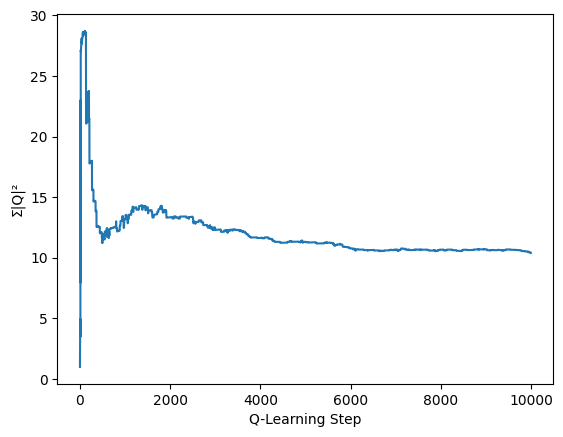

In [16]:
recycler_states = ["low", "high"]
recycler_actions = ["search", "wait", "charge"]

def recycler_next_state(x,a):
    p_h = 0.8 # probability of remaining high battery upon searching
    p_l = 0.7 # probability of remaining low battery upon searching
    # (x, x_next, action) -> probability
    prob_matrix = np.array([
            [
                [p_l,    1.0,    0.0], # low to low
                [1-p_l,  0.0,    1.0], # low to high
            ], [
                [1-p_h,  0.0,    0.0], # high to low
                [p_h,    1.0,    1.0], # high to high
            ],
        ])
    return np.random.choice(recycler_states, p=prob_matrix[recycler_states.index(x),:,recycler_actions.index(a)])

def recycler_reward(x,x_next,a):
    r_s = 1 # reward for searching
    r_w = 0.1 # reward for waiting
    r_p = -10 # reward for running out of battery (low -> high)
    # (x, x_next, action) -> reward
    reward_matrix = np.array([
            [
                [r_s,   r_w,     np.nan], # low to low
                [r_p,   np.nan,  0], # low to high
            ], [
                [r_s,   np.nan,  np.nan], # high to low
                [r_s,   r_w,     0], # high to high
            ],
        ])
    return reward_matrix[recycler_states.index(x),recycler_states.index(x_next),recycler_actions.index(a)]

recycler = Robot(
    state_space = recycler_states, # low, high
    action_space = recycler_actions, # search, wait, charge
    discount = 0.5,
    next_state = recycler_next_state,
    reward = recycler_reward,
)

recycler.reset_Q()
recycler.train_Q(
    learning_rate = lambda n : 1/(1+0.1*n),
    min_iterations = 10**4,
    tolerance = 10**(-2),
    plot=True,
)

print(f"Q matrix:\n{recycler.Q}\n")
for state in recycler_states:
    value, best_action = recycler.value_action(state)
    print("Max value of state `%s` is %f, achieved by taking action `%s`." % (state, value, best_action))